Task 0 — Setup & Imports

In [1]:
# Task 0: imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)


Task 1 — Load data, separate ID, check/handle nulls

In [2]:
# Task 1: load & inspect
PATH = "CC GENERAL.csv"  # adjust if needed
df = pd.read_csv(PATH)

# keep CUST_ID aside (non-numeric, not used for PCA/KMeans)
id_col = next((c for c in df.columns if c.lower() in ("cust_id","customer_id","id")), None)
ids = df[id_col] if id_col else pd.Series(np.arange(len(df)), name="id")

# numeric features only
num = df.select_dtypes(include=[np.number]).copy()

# null overview
display(df.isna().sum().sort_values(ascending=False).to_frame("NullCount").head(20))

# handle nulls (median is robust)
imputer = SimpleImputer(strategy="median")
X_num = pd.DataFrame(imputer.fit_transform(num), columns=num.columns, index=num.index)


,NullCount
MINIMUM_PAYMENTS,313
CREDIT_LIMIT,1
CUST_ID,0
BALANCE,0
PRC_FULL_PAYMENT,0
PAYMENTS,0
PURCHASES_TRX,0
CASH_ADVANCE_TRX,0
CASH_ADVANCE_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


Task 2 — Standardize features

In [3]:
# Task 2: scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)


Task 3 — PCA (all columns) & choose components for ≥85% variance

Components needed for ≥85% variance: 8


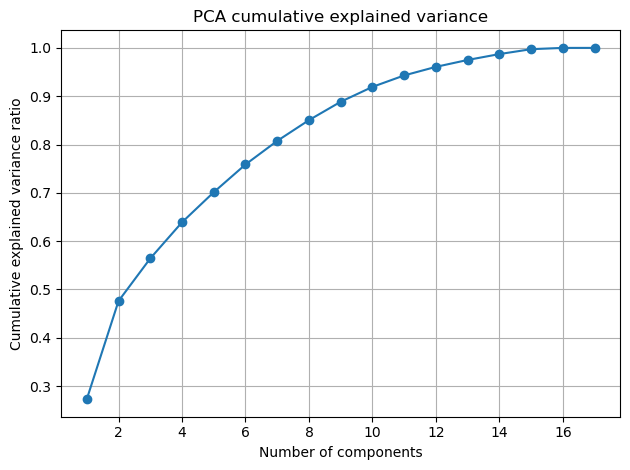

In [4]:
# Task 3: full PCA to see cumulative EV
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

cum_ev = np.cumsum(pca_full.explained_variance_ratio_)
n_components_85 = np.argmax(cum_ev >= 0.85) + 1
print("Components needed for ≥85% variance:", n_components_85)

# plot: components vs cumulative explained variance
plt.figure()
plt.plot(range(1, len(cum_ev)+1), cum_ev, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("PCA cumulative explained variance")
plt.grid(True)
plt.tight_layout()
plt.show()


Task 4 — PCA to 2D for visualization

In [5]:
# Task 4: 2 principal components (for plotting/clustering)
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X_scaled)

pc_df = pd.DataFrame(X_pca2, columns=["PC1","PC2"])
pc_df[id_col if id_col else "id"] = ids.values
pc_df.head()


,PC1,PC2,CUST_ID
0,-1.683649,-1.072241,C10001
1,-1.134085,2.509150,C10002
2,0.969395,-0.383577,C10003
3,-0.888220,0.004648,C10004
4,-1.600021,-0.683795,C10005


Task 5 — Interpret PCA via covariance & find strongest pair

In [6]:
# Task 5: interpret PCA with get_covariance() and find largest |cov|
cov = pca2.get_covariance()                     # covariance in original feature space
cov_df = pd.DataFrame(cov, index=X_num.columns, columns=X_num.columns)

# find pair with largest absolute off-diagonal covariance
cov_abs = cov_df.abs().copy()
np.fill_diagonal(cov_abs.values, 0.0)
i, j = np.unravel_index(np.argmax(cov_abs.values), cov_abs.shape)
top_pair = (cov_df.index[i], cov_df.columns[j], cov_df.values[i, j])

print("Top covariance pair (by |cov|):", top_pair[0], "<->", top_pair[1], "| covariance =", top_pair[2])
cov_df.head()


Top covariance pair (by |cov|): PURCHASES <-> PURCHASES_TRX | covariance = 0.6483212539334364


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1.102060,0.201301,0.215687,0.214113,0.116517,0.497636,-0.088487,0.099823,-0.093550,0.464889,0.464823,0.137538,0.362154,0.406203,0.221304,-0.165222,0.028473
BALANCE_FREQUENCY,0.201301,0.701899,0.215738,0.192153,0.157023,0.153790,0.084851,0.136641,0.066671,0.119873,0.134159,0.182905,0.192755,0.226384,0.094361,-0.007105,0.037944
PURCHASES,0.215687,0.215738,1.283934,0.583985,0.558756,0.012259,0.513204,0.488419,0.436757,-0.097861,-0.032145,0.648321,0.380241,0.473270,0.124741,0.197841,0.134579
ONEOFF_PURCHASES,0.214113,0.192153,0.583985,1.090233,0.468651,0.045770,0.416431,0.409511,0.353091,-0.047293,0.006838,0.543941,0.339199,0.418993,0.118623,0.151137,0.112906
INSTALLMENTS_PURCHASES,0.116517,0.157023,0.558756,0.468651,1.053853,-0.055166,0.448315,0.402405,0.383939,-0.144543,-0.088621,0.533484,0.275784,0.349130,0.076962,0.190109,0.110751


Task 6 — K-Means (k=2..11) on PCA-2D & Elbow

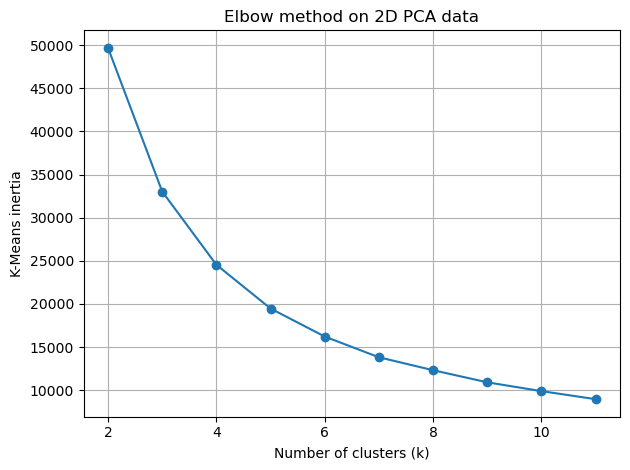

Heuristic elbow k: 5


In [7]:
# Task 6: elbow method on 2D PCA space
ks = range(2, 12)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    km.fit(X_pca2)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(ks), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("K-Means inertia")
plt.title("Elbow method on 2D PCA data")
plt.grid(True)
plt.tight_layout()
plt.show()

# optional: automatic elbow (distance-to-line heuristic)
x1, y1 = 2, inertias[0]
x2, y2 = 11, inertias[-1]
dists = []
for k, sse in zip(ks, inertias):
    num = abs((y2 - y1)*k - (x2 - x1)*sse + x2*y1 - y2*x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    dists.append(num/den if den != 0 else 0)
k_elbow = list(ks)[int(np.argmax(dists))]
print("Heuristic elbow k:", k_elbow)


Task 7 — Final K-Means with chosen k & visualize clusters

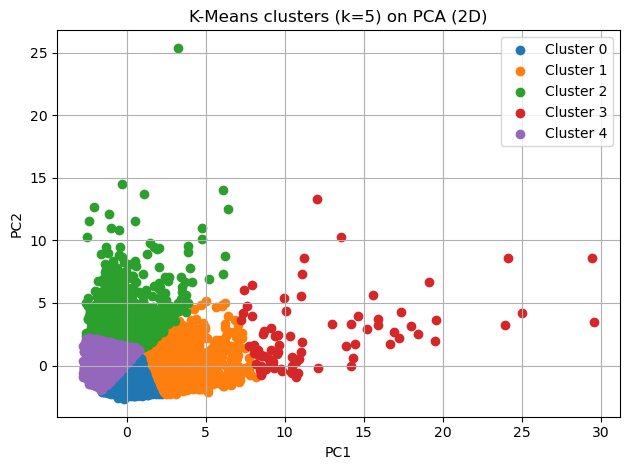

In [8]:
# Task 7: fit final model at chosen k (use k_elbow or your visual pick)
K_FINAL = k_elbow  # or overwrite with the k you see as the elbow
km_final = KMeans(n_clusters=K_FINAL, n_init=10, random_state=RANDOM_STATE)
labels = km_final.fit_predict(X_pca2)

plt.figure()
for lbl in np.unique(labels):
    mask = labels == lbl
    plt.scatter(X_pca2[mask, 0], X_pca2[mask, 1], label=f"Cluster {lbl}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means clusters (k={K_FINAL}) on PCA (2D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Task 8 — Export labeled data

In [9]:
# Task 8: export clusters with PC scores
out = pc_df.copy()
out["cluster"] = labels
out_path = "cc_clusters.csv"
out.to_csv(out_path, index=False)
print("Saved:", out_path)
out.head()


Saved: cc_clusters.csv


,PC1,PC2,CUST_ID,cluster
0,-1.683649,-1.072241,C10001,4
1,-1.134085,2.509150,C10002,2
2,0.969395,-0.383577,C10003,0
3,-0.888220,0.004648,C10004,4
4,-1.600021,-0.683795,C10005,4
